## Model Eval, Final Feature Selection, Final Model Selection & Eval
<a name=top />

In [1]:
import pandas as pd
import numpy as np
import pipeline as p
import fitting as f

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('precision', 3)

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# plt.style.use('fivethirtyeight')

In [2]:
# Machine Learning Imports
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve

from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib

import warnings
warnings.filterwarnings("ignore")

import scipy.stats as stats

In [3]:
df = p.open_pkl('Data/model_df3.pkl')
target = 'elo_delta1'
y = df[target]
X = df.drop(columns=target)

In [4]:
model_cols = p.open_pkl('Data/model_cols.pkl')

In [5]:
len(model_cols)

15

In [6]:
train_df = p.open_pkl('Data/train_df.pkl')
test_df = p.open_pkl('Data/test_df.pkl')

In [7]:
X_test = test_df[model_cols]
y_test = test_df[target]

In [8]:
train_df.reset_index(inplace=True)

In [9]:
alpha = 0.1729
el_one = 0.714
model = make_pipeline(PolynomialFeatures(2), StandardScaler(), ElasticNet(alpha=alpha, l1_ratio=el_one))

### Performance on Training Set

In [10]:
f.assess_model_elasticnetcv(train_df, model_cols, target, 2, False, True)

[0.4164576058092897, 0.4339542276267181, 0.3831641848633033, 0.36128057881564146, 0.3500366948504973]
[329.1937892309229, 292.9959892828527, 380.07651355786186, 356.7488663045939, 342.9121534653723]
[0.16116965129576896, 0.18182983172227998, 0.24291900096948893, 0.15298802820285895, 0.12567543142467397]
[0.5, 0.99, 0.99, 0.99, 0.1]


[0.38897865839309, 340.3854623683207, 0.17291638872301415, 0.714]

## Apply to Test set

In [11]:
model.fit(X_test, y_test)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=0.1729, copy_X=True, fit_intercept=True, l1_ratio=0.714,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [12]:
r2_test = model.score(X_test, y_test)
mse_test = mean_squared_error(y_test, model.predict(X_test))
r2_test, mse_test

(0.38307995255295313, 330.54128266883816)

In [13]:
import math

In [14]:
math.sqrt(340.4)

18.4499322491981

### Final model = fit to all data

In [15]:
model.fit(X[model_cols], y)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=0.1729, copy_X=True, fit_intercept=True, l1_ratio=0.714,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [16]:
joblib.dump(model, 'final_model_fit_to_games.joblib')

['final_model_fit_to_games.joblib']

### Plot actual vs predict, residuals:

In [17]:
test_df['y_pred'] = model.predict(X_test[model_cols])
test_df['resid'] = test_df[target] - test_df['y_pred']

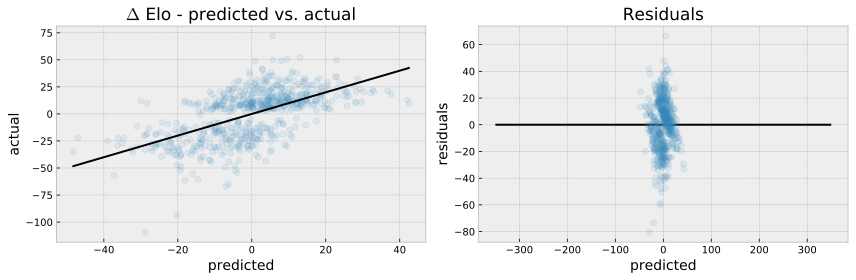

In [18]:
# plt.style.use('ggplot')
# plt.style.use('kendra')
# plt.style.use('seaborn-muted')
plt.style.use('bmh')

fst, fsa = 17, 14

fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.tight_layout()

plt.subplot(1,2,1)
plt.plot(test_df['y_pred'], test_df[target], 'o', alpha=0.1)
plt.plot(test_df['y_pred'], test_df['y_pred'], color='black', lw=2)
plt.xlabel('predicted', fontsize=fsa)
plt.ylabel('actual', fontsize=fsa)
plt.title('$\Delta$ Elo - predicted vs. actual', fontsize=fst)

plt.subplot(1,2,2)
plt.plot(test_df['y_pred'], test_df['resid'], 'o', alpha=0.1)
plt.hlines(0, -350, 350, color='black', lw=2)
plt.xlabel(r'predicted', fontsize=fsa)
plt.ylabel('residuals', fontsize=fsa)
plt.title('Residuals', fontsize=fst)


plt.tight_layout();
plt.savefig('Images/Final_Model_on_Test_noQQ.svg', dpi=300, transparent=False)

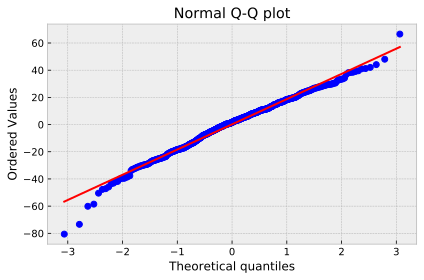

In [19]:
plt.figure(figsize=(6,4))

stats.probplot(test_df['resid'], dist="norm", plot=plt)
plt.title('Normal Q-Q plot');

plt.tight_layout()
plt.savefig('Images/QQplot.svg', dpi=300, transparent=False)

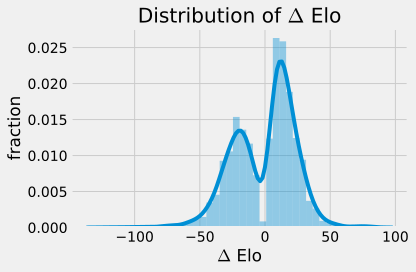

In [20]:
plt.style.use('fivethirtyeight')
sns.distplot(df[target])
plt.xlabel(r'$\Delta$ Elo')
plt.ylabel('fraction')
plt.title(r'Distribution of $\Delta$ Elo');
plt.tight_layout()
plt.savefig('Images/delta_Elo_dist.svg', dpi=300, transparent=False);

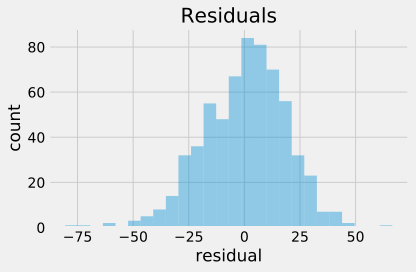

In [21]:
plt.style.use('fivethirtyeight')
sns.distplot(test_df['resid'], kde=False)
plt.xlabel(r'residual')
plt.ylabel('count')
plt.title(r'Residuals');
plt.tight_layout()
plt.savefig('Images/residuals_hist.svg', dpi=300, transparent=False);

## Explore Data

In [22]:
df['y_pred'] = model.predict(df[model_cols])
df['resid'] = df[target] - df['y_pred']
df['sq_err'] = df['resid']**2

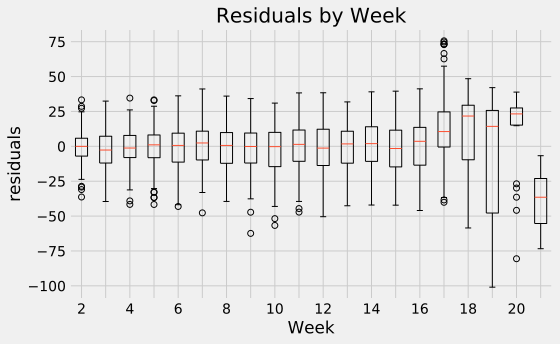

In [23]:
wk_resids = []
labels = []
for i in range(2,22):
    wk_resids.append(df[df['week'] == i]['resid'])
    if i%2==0:
        labels.append(str(i))
    else:
        labels.append('')

plt.figure(figsize=(8,5))
plt.boxplot(wk_resids, labels=labels);
plt.xlabel('Week')
plt.ylabel('residuals')
plt.title('Residuals by Week');
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('Images/Boxplot_resids_vs_week.svg', dpi=300, transparent=False);

In [24]:
team_list = df['team1'].unique()
team_list.sort()

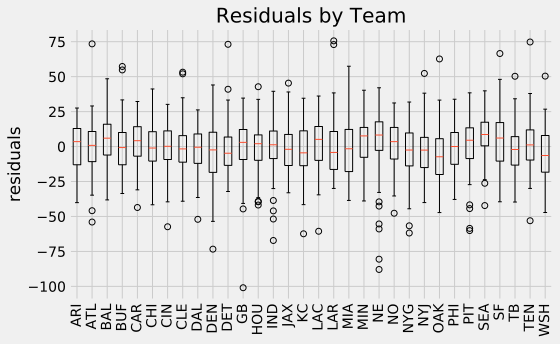

In [25]:
tm_resids = []
# labels = []
for tm in team_list:
    tm_resids.append(df[df['team1'] == tm]['resid'])
#     if i%2==0:
#         labels.append(str(i))
#     else:
#         labels.append('')

plt.figure(figsize=(8,5))
plt.boxplot(tm_resids, labels=team_list);
# plt.xlabel('Team', rotation=90)
plt.xticks(rotation=90)
plt.ylabel('residuals')
plt.title('Residuals by Team');
plt.tight_layout()
plt.savefig('Images/Resids_vs_team.svg', dpi=300, transparent=False);

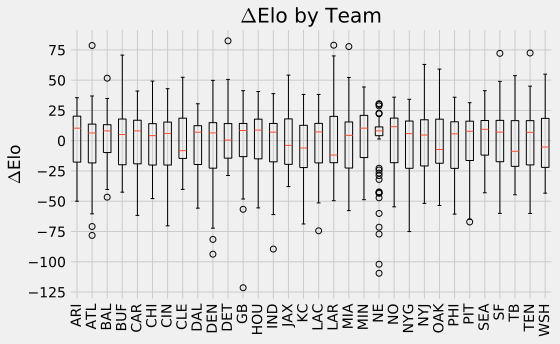

In [26]:
tm_deltas = []
# labels = []
for tm in team_list:
    tm_deltas.append(df[df['team1'] == tm][target])
#     if i%2==0:
#         labels.append(str(i))
#     else:
#         labels.append('')

plt.figure(figsize=(8,5))
plt.boxplot(tm_deltas, labels=team_list);
# plt.xlabel('Team', rotation=90)
plt.xticks(rotation=90)
plt.ylabel(r'$\Delta$Elo')
plt.title(r'$\Delta$Elo by Team');
plt.tight_layout()
plt.savefig('Images/deltaElo_vs_team.svg', dpi=300, transparent=False);

If time: bar plot of mean square error by team

In [27]:
team_mse = df.groupby('team1')['sq_err'].mean()

In [38]:
df['rmse'] = np.sqrt(df['sq_err'])

In [39]:
team_rmse = df.groupby('team1')['rmse'].mean()

In [28]:
team_mse.sort_values(inplace=True, ascending=True)
labels = list(team_mse.index)

In [40]:
team_rmse.sort_values(inplace=True, ascending=True)
labels2 = list(team_rmse.index)

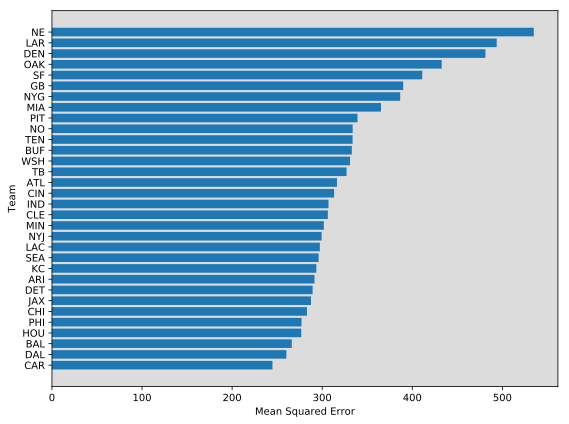

In [29]:
plt.rcdefaults()
plt.figure(figsize=(8,6))
plt.rcParams['axes.facecolor'] = 'Gainsboro'
plt.rcParams['figure.facecolor'] = 'Gainsboro'

plt.barh(range(len(team_mse)), team_mse.sort_values(ascending=True), tick_label=labels)
plt.xlabel('Mean Squared Error')
plt.ylabel('Team')
# plt.title('MSE by Team');
plt.tight_layout()
# plt.savefig('Images/MSE_by_team.svg', dpi=300, transparent=False);

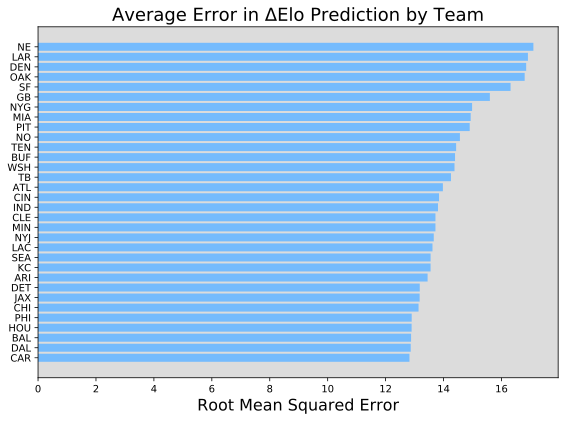

In [46]:
plt.rcdefaults()
plt.figure(figsize=(8,6))
plt.rcParams['axes.facecolor'] = 'Gainsboro'
plt.rcParams['figure.facecolor'] = 'Gainsboro'

plt.barh(range(len(team_mse)), team_rmse.sort_values(ascending=True), tick_label=labels, color='xkcd:sky blue')
plt.xlabel('Root Mean Squared Error', fontsize=16)
# plt.ylabel('Team')
plt.title('Average Error in $\Delta$Elo Prediction by Team', fontsize=18);
plt.tight_layout()
plt.savefig('Images/RMSE_by_team.svg', dpi=300, transparent=False);

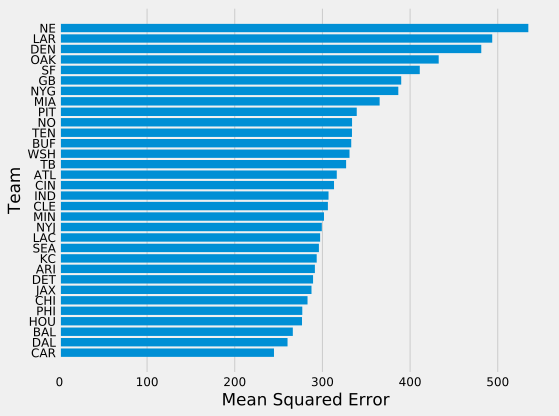

In [30]:
# plt.rcdefaults()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))
# plt.rcParams['axes.facecolor'] = 'Gainsboro'
# plt.rcParams['figure.facecolor'] = 'Gainsboro'

plt.barh(range(len(team_mse)), team_mse.sort_values(ascending=True), tick_label=labels)
plt.xlabel('Mean Squared Error')
plt.ylabel('Team')
plt.tick_params(labelsize=12)
# plt.title('MSE by Team');
ax = plt.gca()
ax.grid(b=False, axis='y')
# ax.get_yticklabels().set_fontsize(12)
plt.tight_layout()
plt.savefig('Images/MSE_by_team_fte.svg', dpi=300, transparent=False);

### Learning Curve

In [31]:
train_sizes = [10, 100, 500, 1000, 1693]

In [32]:
train_sizes, train_scores, test_scores = learning_curve(
    model, df[model_cols], df[target], cv=3, train_sizes=train_sizes, scoring='neg_mean_squared_error')

In [33]:
train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

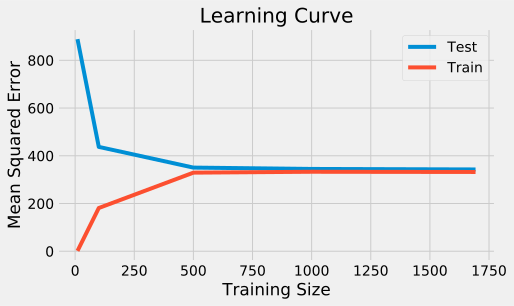

In [34]:
plt.figure(figsize=(7,4))

plt.plot(train_sizes, test_mean, label='Test')
plt.plot(train_sizes, train_mean, label='Train')

plt.legend()
plt.xlabel('Training Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve');
plt.savefig('Learning_Curve.svg', dpi=300, transparent=False);
# plt.tight_layout(rect=[0, 0, 1, 1]);

### More Exploration

In [35]:
df.columns

Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1',
       'elo2', 'elo_prob1', 'score1', 'score2', 'result1', 'elo_delta1', 'OT',
       'time', 'week', 'WinPct1', 'TimePossMins1', 'FirstD_SA1', 'PassY_SA1',
       'PtsOpp_SA1', 'PtsTm_SA1', 'RushY_SA1', 'TO_SA1', 'DefTO_SA1',
       'TotY_SA1', 'RushAtt_SA1', 'RushTDs_SA1', 'PassCmp_SA1', 'PassAtt_SA1',
       'PassTDs_SA1', 'INT_SA1', 'SacksO_SA1', 'Fumbles_SA1', 'Penalies_SA1',
       'PenY_SA1', 'ThirdDConv_SA1', 'ThirdDAtt_SA1', 'FourthDAtt_SA1',
       'PassCompPct_SA1', 'PassRating_SA1', 'WinPct2', 'TimePossMins2',
       'FirstD_SA2', 'PassY_SA2', 'PtsOpp_SA2', 'PtsTm_SA2', 'RushY_SA2',
       'TO_SA2', 'DefTO_SA2', 'TotY_SA2', 'RushAtt_SA2', 'RushTDs_SA2',
       'PassCmp_SA2', 'PassAtt_SA2', 'PassTDs_SA2', 'INT_SA2', 'SacksO_SA2',
       'Fumbles_SA2', 'Penalies_SA2', 'PenY_SA2', 'ThirdDConv_SA2',
       'ThirdDAtt_SA2', 'FourthDAtt_SA2', 'PassCompPct_SA2', 'PassRating_SA2',
       'Ones', 'y_pred', 'res

In [36]:
df[(df['Week'] == 5) & (df['Season'] == 2017)][['Team','Opp','Result','EloBefore','EloAfter','EloDelta','y_pred','resid']]

KeyError: 'Week'

In [ ]:
p.pkl_this('Data/final_df_with_pred.pkl', df)

In [ ]:
df.columns